# Part 2: Fundamentals

# Chapter 3: Creating Node Representations with DeepWalk

## Our goal is to produce high quality embeddings

In [2]:
import numpy as np

In [3]:
context_size = 2

In [5]:
raw_text = """
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id 
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Donec tristique ultrices tortor at accumsan.
"""


In [7]:
len(raw_text) ### full string length - 1101 characters

1101

In [10]:
text = raw_text.split() ## split by space to get the words into list

In [13]:
len(text) #### words 156

156

In [14]:
skipgrams = []

for i in range(context_size, len(text) - context_size):
    array = [text[j] for j in np.arange(i - context_size, i+context_size+1) if j!=i]
    
    skipgrams.append((text[i], array))

In [16]:
skipgrams[0:2]

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']),
 ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]

In [17]:
### focus on vocab

vocab = set(text)

In [18]:
vocab_size = len(vocab)

In [21]:
vocab_size # length of our vocab 121

121

In [22]:
## setting hyperparameter N which is the size of our embedding
N = 10

### next is basically a 2 layer neural network with a projection layer and fully connected layer

### one catch is that there is no activation function

In [24]:
##using gensim

from gensim.models.word2vec import Word2Vec

In [25]:
w2vmodel = Word2Vec([text], sg=1, vector_size=10, min_count=0, window=2, workers=2, seed=0)

In [28]:
### check shape

print(f'Shape of W_embed: {w2vmodel.wv.vectors.shape}')

Shape of W_embed: (121, 10)


In [29]:
w2vmodel.corpus_count

1

In [30]:
w2vmodel.train([text], total_examples=w2vmodel.corpus_count, epochs=10)

(690, 1560)

In [31]:
# Print a word embedding
print('\nWord embedding =')
print(w2vmodel.wv[0])


Word embedding =
[ 0.07156403  0.03257632  0.00209916 -0.04374931 -0.03398107 -0.08656936
 -0.09047253 -0.09552431 -0.06482638  0.0660186 ]


### DeepWalk

In [32]:
### nodes that are close are similar

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import random
random.seed(0)

In [42]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

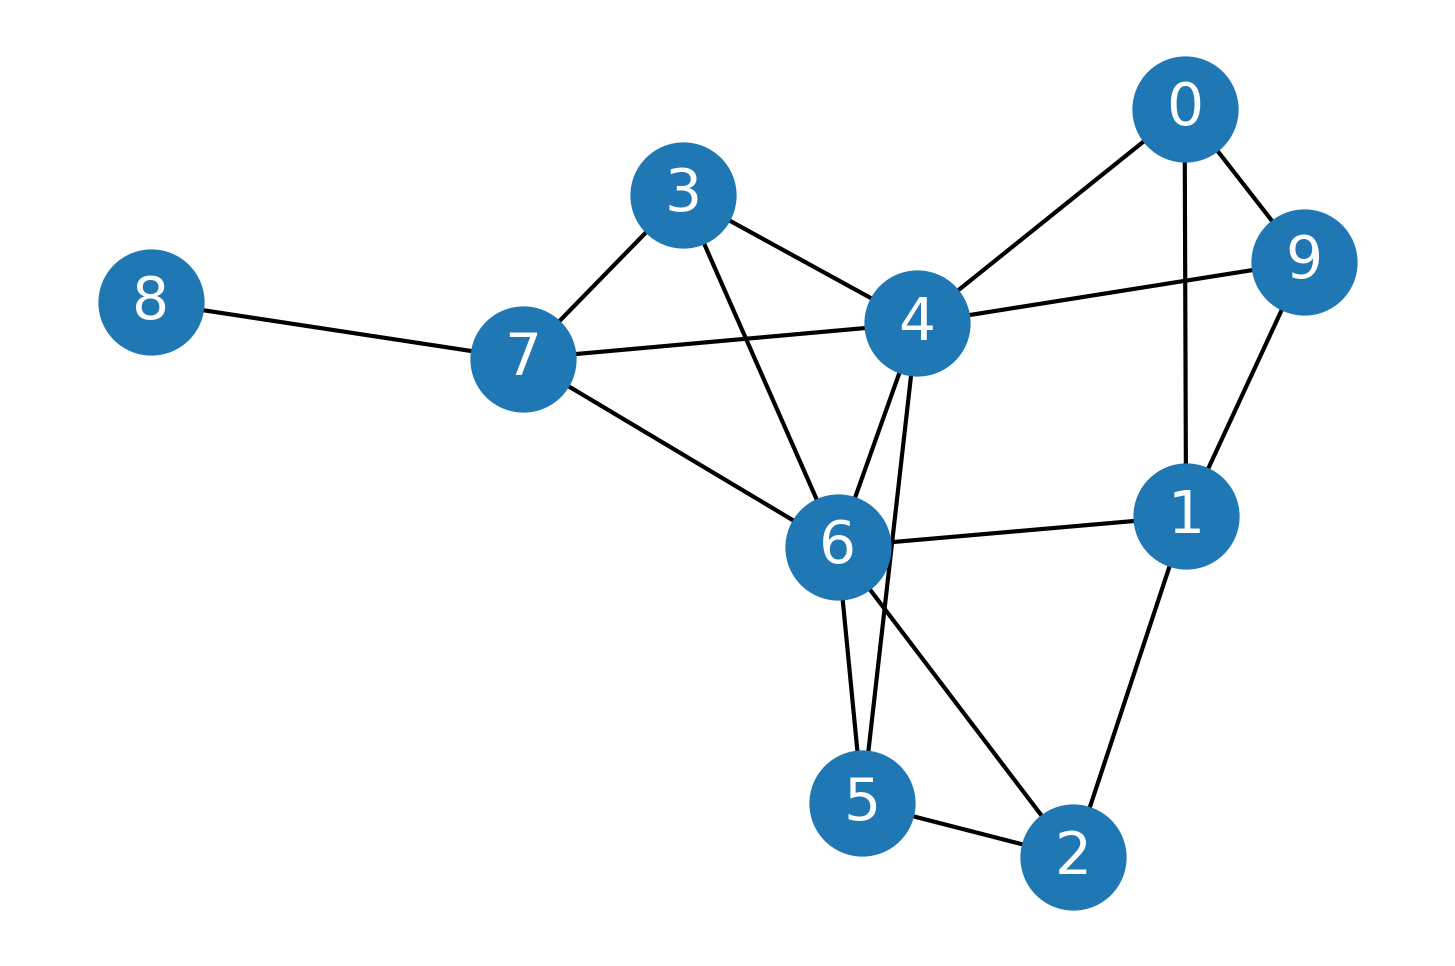

In [43]:
plt.figure(dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 font_size=14,
                 font_color='white'
                 )
plt.show()

In [48]:
def random_walk(G, start,length):
    walk = [str(start)]
    
    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
        
        
    return walk

In [49]:
random_walk(G, 0, 10)

['0', '9', '4', '6', '3', '4', '5', '4', '3', '6', '4']

In [50]:
G = nx.karate_club_graph()

In [51]:
labels = []

for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

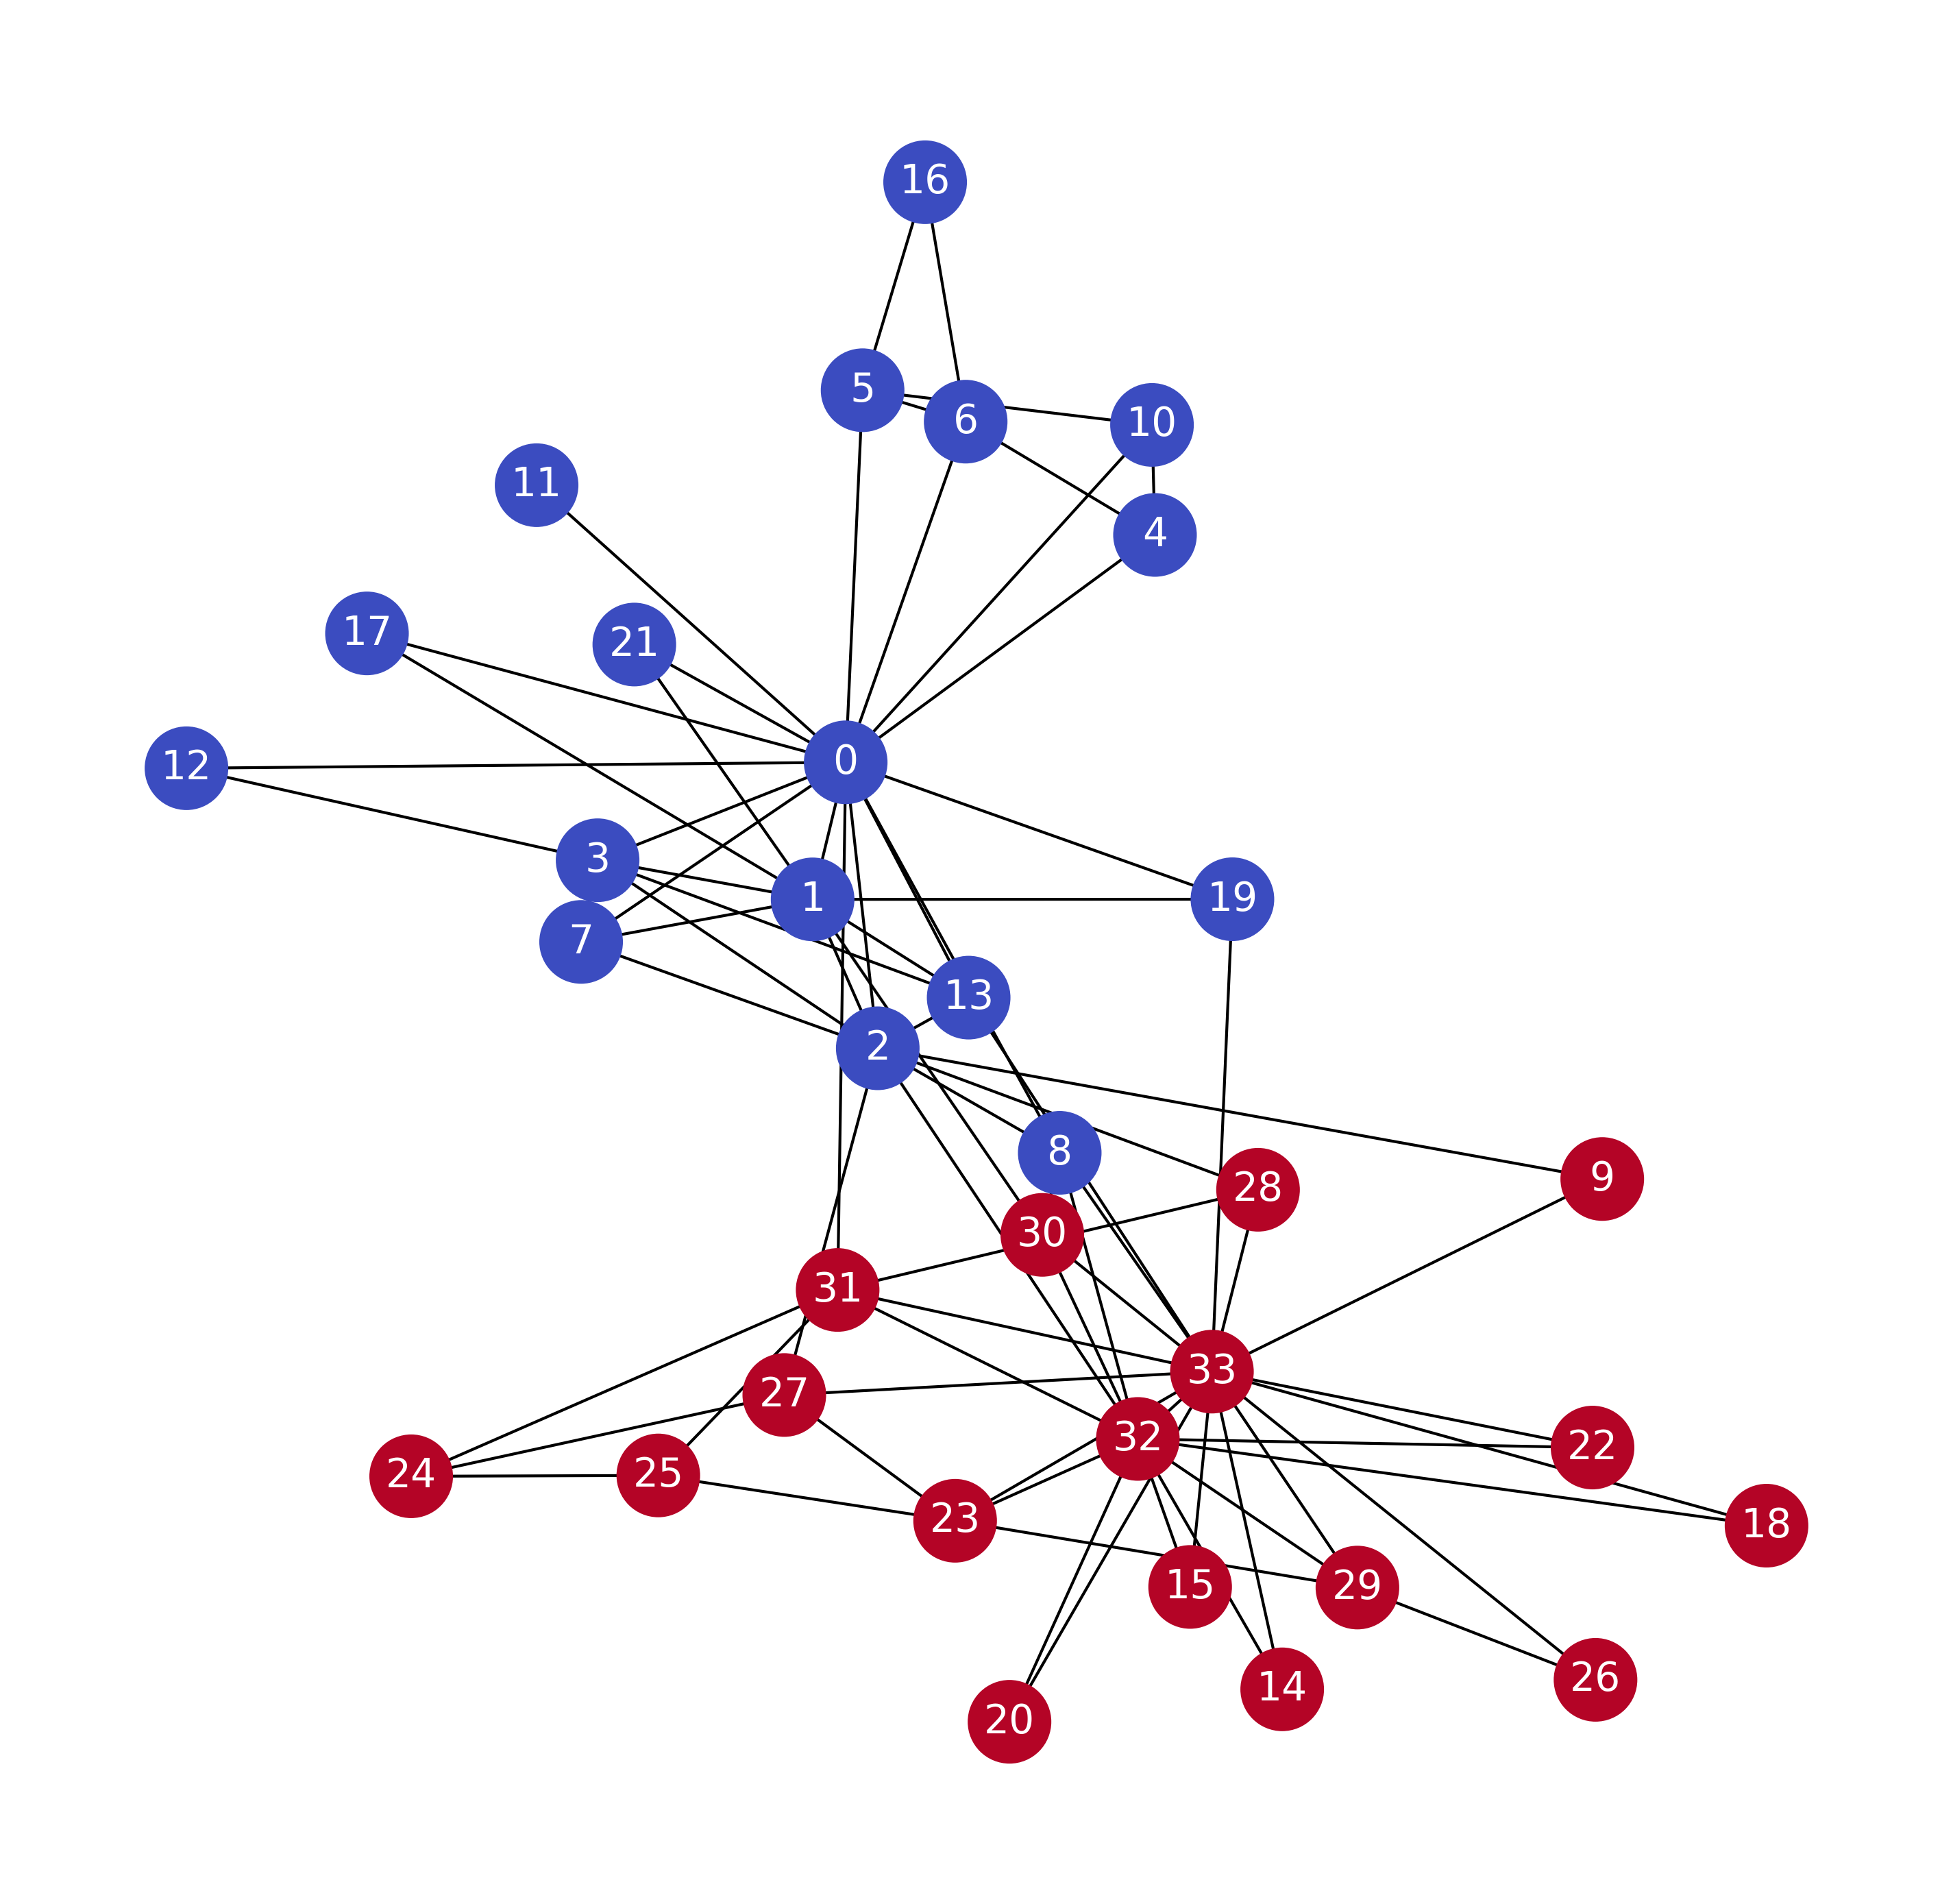

In [53]:
plt.figure(figsize=(12,12), dpi=300)
plt.axis('off')

nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=800,
                 font_size=14,
                 font_color='white',
                 cmap='coolwarm'
                 )
plt.show()

In [55]:
walks = []

for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(G, node, 10))

In [56]:
print(walks[0])

['0', '5', '6', '0', '4', '10', '5', '16', '5', '16', '6']


### now implement Word2vec on the random walks

In [57]:
from gensim.models.word2vec import Word2Vec

In [83]:
model = Word2Vec(walks,
                 hs=1,   # Hierarchical softmax
                 sg=1,   # Skip-gram
                 vector_size=1000,
                 window=10,
                 workers=1,
                 seed=1)

print(f'Shape of embedding matrix: {model.wv.vectors.shape}')

Shape of embedding matrix: (34, 1000)


In [85]:
# Build vocabulary
model.build_vocab(walks)

# Train model
model.train(walks, total_examples=model.corpus_count, epochs=100, report_delay=1)

(623752, 2992000)

In [86]:
# Most similar nodes
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
    print(f'   {similarity}')

# Similarity between two nodes
print(f"\nSimilarity between node 0 and 4: {model.wv.similarity('0', '4')}")

Nodes that are the most similar to node 0:
   ('10', 0.718189001083374)
   ('4', 0.7063395380973816)
   ('6', 0.6254416704177856)
   ('5', 0.6118350625038147)
   ('11', 0.6012638211250305)
   ('16', 0.5996977686882019)
   ('12', 0.5974043607711792)
   ('21', 0.5717853903770447)
   ('3', 0.5440371632575989)
   ('1', 0.5416150093078613)

Similarity between node 0 and 4: 0.7063395977020264


### Plot the embeddings using t-SNE and we expect that the plot should be similar to the graph structure

In [87]:
from sklearn.manifold import TSNE

/home/shashank/anaconda3/envs/pygeo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


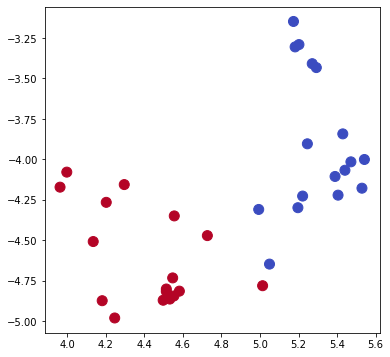

In [88]:
# Preprocess word vectors and label
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

# Train TSNE
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

# Plot TSNE
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

### We can have random Forest model here 

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [90]:
# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

In [91]:
# Train classifier
clf = RandomForestClassifier(random_state=1)
clf.fit(nodes_wv[train_mask], labels[train_mask])

RandomForestClassifier(random_state=1)

In [92]:
# Evaluate accuracy
y_pred = clf.predict(nodes_wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Accuracy = {acc*100:.2f}%')

Accuracy = 95.45%
